# Классификация комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет выявлять токсичные комментарии, чтобы отправлять их на модерацию. 

**Задача:** разработать модель для классификации комментариев пользователей на нейтральные и токсичные.<br> 
*Требования к качеству модели:* приемлимое качество, оцененное по F1-мере, 0.75 и выше.

**Описание данных**

Набор комментариев с разметкой о токсичности.

*text* - текст комментария<br>
*toxic* - целевой признак, 1-комментарий токсичный, 0-нейтральный.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-1">Обзор и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.1">Очистка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2">Лемматизация</a></span></li><li><span><a href="#Облака-слов,-размеченные-данные" data-toc-modified-id="Облака-слов,-размеченные-данные-1.3">Облака слов, размеченные данные</a></span></li><li><span><a href="#Разделение-датасета" data-toc-modified-id="Разделение-датасета-1.4">Разделение датасета</a></span></li></ul></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-2">Исследование моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3">Тестирование</a></span></li><li><span><a href="#Облака-слов,-предсказания" data-toc-modified-id="Облака-слов,-предсказания-4">Облака слов, предсказания</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5">Общий вывод:</a></span></li></ul></div>

In [1]:
#!pip install wordcloud

In [2]:
# Importing Libraries 
import os
import random
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from tqdm import tqdm
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liubovshubina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liubovshubina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.precision", 4)

%matplotlib inline

## Обзор и подготовка данных

In [4]:
# data path
path = os.path.join(os.path.dirname(os.getcwd()), '13_NLP')

In [5]:
# reading file
try:
    data = pd.read_csv(os.path.join(path, 'toxic_comments.csv'), index_col=0)
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [6]:
# get first and last 5 rows
data

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in r...",0
159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61....,0
159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159449,And it looks like it was actually you who put on the speedy to have the first version deleted no...,0


In [7]:
# get information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
# percentage of toxic and non-toxic comments
print('Процент нетоксичных(0)/токсичных(1) комментариев:')
data['toxic'].value_counts(normalize=True)*100

Процент нетоксичных(0)/токсичных(1) комментариев:


0    89.8388
1    10.1612
Name: toxic, dtype: float64

In [9]:
# 10 random comments
for i in random.sample(range(0, 150000), 10):
    print('Comment:', i)
    print(data.text[i])
    print('***')

Comment: 30771
You deserve this and rest what people write or will write about you:
http://antandrus.tripod.com and encyclopediadramatica rules!
***
Comment: 4947
"

 Please do not vandalize pages, as you did with this edit to Tire. If you continue to do so, you will be blocked from editing.    "
***
Comment: 111079
"
No, my claim is simply that ""many"" scholars from a variety of political persuasions consider anarcho-capitalism to be a type of anarchism. There are many sources listed, and the sources are credible by Wikipedia standards. You have no argument to contradict that. "
***
Comment: 82826
stop! 

please stop deleting my stuff, and give me a couple of GOOD reasons as to why you think you can delete
my stuff about the museum which you know nothing about!
***
Comment: 3702
"

Sockpuppetry case
 
You have been accused of sockpuppetry. Please refer to Wikipedia:Suspected sock puppets/ㄏㄨㄤㄉㄧ for evidence. Please make sure you make yourself familiar with notes for the suspect before

In [10]:
# some comments
df = data.loc[[1, 17, 37, 41, 48, 101, 162]]
for text in df['text']:
    print('Comment:')
    print(text)
    print('***')

Comment:
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
***
Comment:
REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski
***
Comment:
pretty much everyone from warren county/surrounding regions was born at glens falls hospital. myself included. however, i'm not sure this qualifies anyone as being a glens falls native. rachel ray is, i believe, actually from the town of lake luzerne.  —The preceding unsigned comment was added by 70.100.229.154  04:28:57, August 19, 2007 (UTC)
***
Comment:
TFD 

I think we just eced. I think we responded to each other without seeing each others responses. I added something in response to yours, but don't know if you saw mine. (T/C//WP:CHICAGO/WP:FOUR)
***
Comment:
"
As for your claims of ""stalking"", that is absolute rubbish and serves only to aggravate the situation. I have assumed good faith (and good intentions) on your part, and have never suggested (or seen reason to suggest) that you m

**Вывод:** в данных содержится почти 160 тысяч комментариев. Большинство комментариев не негативные (нетоксичные) - 89.8%, только 10% стоит отправлять на модерацию.

Как видно из примеров, тексты комментариев содержат много информации, которая кажется неважной для классификации: даты, гиперссылки, теги, пунктуация, числа, техническая информация, никнеймы и т.д. Такую информацию стоит удалить.

### Очистка текста

Создадим функцию, с помощью которой постараемся максимально очистить текст перед его векторизацией.

In [11]:
# define function to clean comments
def clean_texts(texts):
    """Функция принимает на вход объект pd.Series
    из строк, каждую строку приводит к нижнему регистру,
    удаляет html теги, техническую информацию, маркеры переноса 
    строки и табуляции, гиперссылки, никнеймы, знаки пунктуации и числа, 
    повторы букв больше 2. Возвращает очищенный объект pd.Series.
    """
    # Lower Casing
    texts = texts.str.lower()
    
    # Removing html tags
    texts=texts.apply(lambda x: BeautifulSoup(x).get_text(separator=" "))
    
    # Removing all lines starting with | or { or < or >
    texts = texts.str.replace('(^|\n)[|{<>].+', ' ')
    
    # Removing all (...) or <...> at the end of lines
    texts = texts.str.replace('[(<].+[>)](\n|$)', '')
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space
    texts = (texts.str.replace('\\n', ' ')
             .str.replace('\n', ' ')
             .str.replace('\n\n', ' ')
             .str.replace('\t',' ')
             .str.replace('\\', ' '))
    
    # Removing all the occurrences of links that starts with 'https'
    texts = texts.str.replace('http\S+', '')
    
    # Removing all the occurrences of text that ends with '.com'
    texts = texts.str.replace('\ [a-z]*\.com', ' ')
    
    # Removing all inside |...| 
    texts = texts.str.replace('\|[^|]+\|', ' ')
    
    # Removing all inside {...}
    texts = texts.str.replace('\{[^\{\}]+\}', ' ')
    
    # Removing all @nicknames 
    texts = texts.str.replace('@\S+', ' ')
    
    # Removing all digits and punctuation (except ')
    texts = texts.str.replace("[^a-z\s']+", ' ')
    
    # Limiting all repeatitions of characters to two characters
    texts = texts.apply(lambda x: re.sub(r'(\w)\1{2,}', r'\1\1', x))

    return texts

Посмотрим, как работает функция на примере - небольшом наборе комментариев.

In [12]:
# Сleaning, example
df['text'] = clean_texts(df['text'])

for text in df['text']:
    print('Comment:')
    print(text)
    print('***')

Comment:
d'aww  he matches this background colour i'm seemingly stuck with  thanks   
***
Comment:
redirect talk voydan pop georgiev  chernodrinski
***
Comment:
pretty much everyone from warren county surrounding regions was born at glens falls hospital  myself included  however  i'm not sure this qualifies anyone as being a glens falls native  rachel ray is  i believe  actually from the town of lake luzerne    the preceding unsigned comment was added by      august     
***
Comment:
tfd   i think we just eced  i think we responded to each other without seeing each others responses  i added something in response to yours  but don't know if you saw mine  
***
Comment:
  as for your claims of  stalking  that is absolute rubbish and serves only to aggravate the situation  i have assumed good faith  and good intentions  on your part  and have never suggested  or seen reason to suggest  that you might have some ulterior motive in mass adding links to one specific company's web page  nor  fo

Видно, что после очистки текст приведен к нижнему регистру, не содержит пунктуации (кроме '), чисел, гиперссылок, технической информации, слов с повторяющимися буквам. 

Применим функцию ко всему датасету.

In [13]:
%%time
# Cleaning texts
data['text'] = clean_texts(data['text'])

CPU times: user 1min 9s, sys: 2.88 s, total: 1min 12s
Wall time: 1min 18s


### Лемматизация

Проведем лемматизацию текста, используя частеречную разметку (part-of-speech tagging), будем преобразовывать только существительные, глаголы, прилагательные и наречия.
Чтобы не учитывать неважные слова, используем набор стоп-слов для английского с добавлением "I'm".

In [14]:
#Importing stopwords from nltk library
stopwords = nltk_stopwords.words('english')+["i'm"]

In [15]:
# Create WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# Pos tag dictionary: Noun, Verb, Adjective and Adverb
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV}

In [16]:
# define function to lemmatize words using POS tag
# and to clean stopwords
def lemmatize_no_stopwords(text):
    '''Функция лемматизирует слова (кроме стоп-слов) 
    в строке, учитывая части речи.
    Принимает на вход строку, возвращает строку из
    лемм без стоп-слов.'''
    
    # add pos-tag to each word
    pos_tagged_text = nltk.pos_tag(text.split())
    
    # lemmatize nouns, verbs, adjectives and adverbs
    # for pos tags not in wordnet_map tag = 'N'
    lem_words = [
        lemmatizer.lemmatize(word, wordnet_map.get(tag[0], wordnet.NOUN)) 
        for word, tag in pos_tagged_text 
        if word not in stopwords]
    
    words_string = " ".join(lem_words)    
    return words_string

In [17]:
# check function 
lemmatize_no_stopwords("the striped bats are hanging on their feet for best")

'striped bat hang foot best'

Кажется, что функция работает корректно. Проведем лемматизацию всех комментариев.

In [18]:
%%time
tqdm.pandas(desc="Lemmatization progress")
# Lemmatization
data['text_lem'] = data['text'].progress_apply(lemmatize_no_stopwords)
data.head()

Lemmatization progress: 100%|██████████| 159292/159292 [13:03<00:00, 203.36it/s]

CPU times: user 12min 48s, sys: 12.9 s, total: 13min 1s
Wall time: 13min 3s


,text,toxic,text_lem
0,explanation why the edits made under my username hardcore metallica fan were reverted they were...,0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new yor...
1,d'aww he matches this background colour i'm seemingly stuck with thanks,0,d'aww match background colour seemingly stick thanks
2,hey man i'm really not trying to edit war it's just that this guy is constantly removing relev...,0,hey man really try edit war guy constantly remove relevant information talk edits instead talk p...
3,more i can't make any real suggestions on improvement i wondered if the section statistics s...,0,can't make real suggestion improvement wonder section statistic later subsection type accident t...
4,you sir are my hero any chance you remember what page that's on,0,sir hero chance remember page that's


Можно видеть, что стоп-слова удаляются, лемматизация проходит: striped не меняется на strip, тк это прилагательное (как и в случае ashamed), went меняется на go, hanging на hang, worked на work. Но есть и некоторые недочеты, так edits не меняется на ед. число edid, вероятно, в следствие [ограничености](https://github.com/nltk/nltk/issues/2567) словаря WordNet.

### Облака слов, размеченные данные

Визуализируем самые частые слова в токсичных и нетоксичных комментариях датасета с помощью облака тэгов "Word cloud". Посмотрим на 100 наиболее частотных слов, специфичных для комментариев, классифицированных как токсичные и нетоксичные.

In [19]:
# Creating TfidfVectorizer object
count_tf_idf_tox = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2),
                                   max_df = 0.8, min_df = 10)
count_tf_idf_neutr = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2),
                                     max_df = 0.8, min_df = 10)
# Vectorizing dataset
tf_idf_toxic = count_tf_idf_tox.fit_transform(data.query('toxic == 1')['text_lem'])
tf_idf_neutr = count_tf_idf_neutr.fit_transform(data.query('toxic == 0')['text_lem'])

print("Размер матрицы токсичных слов:", tf_idf_toxic.shape)
print("Размер матрицы нетоксичных слов:", tf_idf_neutr.shape)

Размер матрицы токсичных слов: (16186, 4621)
Размер матрицы нетоксичных слов: (143106, 60735)


In [20]:
# Frequencies of words in toxic/neutral comments
toxic_freq = pd.DataFrame(
    {'word': count_tf_idf_tox.get_feature_names_out(),
     'freq': np.array(tf_idf_toxic.sum(axis = 0))[0]
    }).sort_values(by = 'freq', ascending = False)[:100]

neutr_freq = pd.DataFrame(
    {'word': count_tf_idf_neutr.get_feature_names_out(),
     'freq': np.array(tf_idf_neutr.sum(axis = 0))[0]
    }).sort_values(by = 'freq', ascending = False)[:100]

In [21]:
print('топ-10 слов в нейтральных комментариях')
print(neutr_freq['word'].head(10).values)
print()
print('топ-10 слов в токсичных комментариях')
print(toxic_freq['word'].head(10).values)

топ-10 слов в нейтральных комментариях
['article' 'page' 'talk' 'wikipedia' 'please' 'edit' 'use' 'make' 'one'
 'would']

топ-10 слов в токсичных комментариях
['fuck' 'go' 'get' 'like' 'page' 'wikipedia' 'suck' 'shit' 'know' 'block']


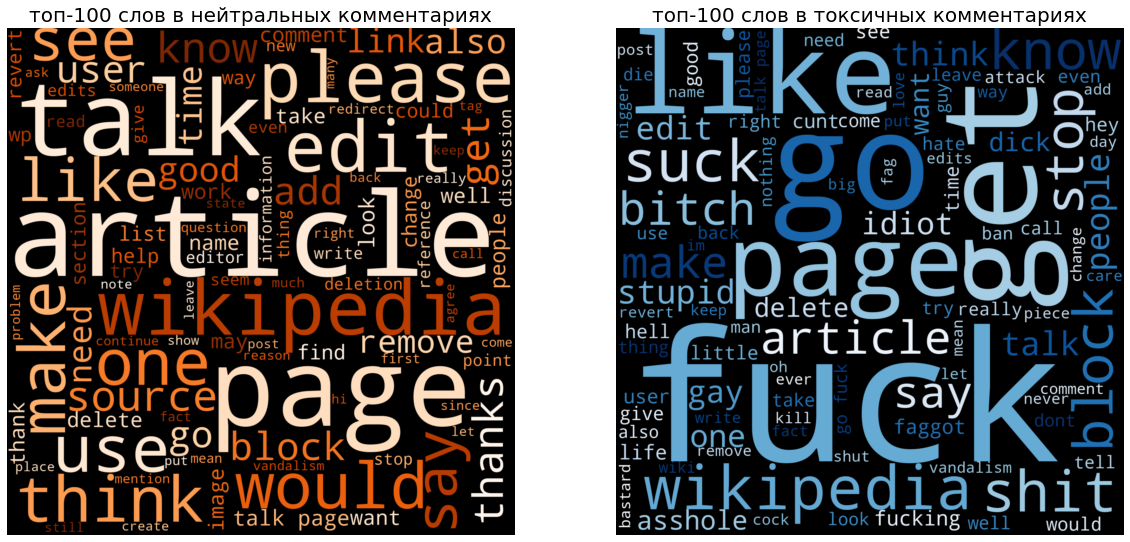

In [22]:
# WordClouds, font size = weight
wordcloud_neutr = WordCloud(background_color="black",
                            colormap = 'Oranges',
                            mask=None, 
                            width=1600,
                            height=1600).generate_from_frequencies(
    dict(neutr_freq.values))

wordcloud_toxic = WordCloud(background_color="black",
                            colormap = 'Blues',
                            mask=None, 
                            width=1600,
                            height=1600).generate_from_frequencies(
    dict(toxic_freq.values))

fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].imshow(wordcloud_neutr, interpolation='bilinear')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')

ax[0].set_title('топ-100 слов в нейтральных комментариях', fontsize = 20)
ax[1].set_title('топ-100 слов в токсичных комментариях', fontsize = 20)

ax[0].axis("off")
ax[1].axis("off")

plt.show()

### Разделение датасета

**Выделение целевой переменной**

In [23]:
# target and features
X = data['text_lem']
y = data['toxic']

**Разделение на обучающую и тестовую выборки**

In [24]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify = y, random_state=123)

# sizes of training/test data
print('Размеры выборок:')
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Размеры выборок:


((143362,), (15930,), (143362,), (15930,))

## Исследование моделей

**Векторизация текста**<br>
Для векторизаци текста применим оценку важности слов с помощью величины TF-IDF. Чтобы не учитывать неважные слова, возможно, оставшиеся после лемматизации, используем стоп-слова. Не будем учитывать редкие слова (встречающиеся реже, чем в 10% комментариев). При построении словаря проверим качество моделей также при игнорировании слов, которые встречаются в более 50 и 75% комментариев, а также при использовании не только слов, но и их биграмм.

**Модели**<br>
Для задачи данного проекта протестируем 3 модели - логистическую регрессию, градиентный бустинг LightGBM и метод опорных векторов с разными гипермараметрами.<br>
Качество моделей оценим по метрике f1.

Для векторизирования текста с разными параметрами и для выбора модели классификации используем pipeline.

In [25]:
# Create the pipeline
pipeline = Pipeline([('tf_idf', TfidfVectorizer(stop_words=stopwords,
                                                min_df=10)), 
                     ('clf', DummyClassifier(random_state=123))])

In [26]:
# Set grid search params
params = [
    {'clf': [LogisticRegression(random_state=123, 
                                solver='saga',
                                max_iter = 1000)],
     'clf__penalty': ['l2', 'elasticnet'],
     'clf__C': [0.1, 1, 10],
     'clf__class_weight': ['balanced', None],
     'tf_idf__max_df': [0.5, 0.75, 1],
     'tf_idf__ngram_range': [(1,1), (1,2)]}, 
    
    {'clf': [LGBMClassifier(random_state=123)],
     'clf__n_estimators': range(50, 100, 10),
     'clf__max_depth': range(20, 50, 10)}, 
    
    {'clf': [LinearSVC(dual=False)],
     'clf__penalty': ['l2', 'l1'],
     'clf__C': [0.1, 1, 10],
     'clf__class_weight': ['balanced', None],
     'tf_idf__max_df': [0.5, 0.75, 1],
     'tf_idf__ngram_range': [(1,1), (1,2)]}
]

In [27]:
# Construct grid search
grid_model = GridSearchCV(pipeline, params,
                          cv=3, verbose=1,
                          scoring='f1', 
                          n_jobs=-1)

In [28]:
%%time
# Fit the grid search object
grid_model.fit(X_train, y_train)

Fitting 3 folds for each of 159 candidates, totalling 477 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

CPU times: user 1min 10s, sys: 40.3 s, total: 1min 50s
Wall time: 1h 11min 56s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(min_df=10,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        DummyClassifier(rand...
                          'tf_idf__ngram_range': [(1, 1), (1, 2)]},
                         {'clf': [LGBMClassifier(random_state=123)],
                          'clf__max_depth': range(20, 50, 10),
                          'clf__n_estimators': range(50, 100, 10)},
                         {'clf': [LinearSVC(C=1, dual=False, penalty='l1')],
                          'clf__C': [0.1, 1, 10],
                          'clf__class_weight': ['balanced', None],
                          'clf__penalty': ['l2', 'l1'],
                          'tf_idf__max_df': [0.5, 0.75, 1],
                          'tf_idf__ngram_range': [(1, 1), (1, 2)]}],
             scoring='f1', verbose=1)

In [29]:
# Hyperparameters of the best model
print('Лучшая модель:')
grid_model.best_params_

Лучшая модель:


{'clf': LinearSVC(C=1, dual=False, penalty='l1'),
 'clf__C': 1,
 'clf__class_weight': None,
 'clf__penalty': 'l1',
 'tf_idf__max_df': 0.5,
 'tf_idf__ngram_range': (1, 1)}

In [30]:
# F1 score
print(f'F1 score: {grid_model.best_score_:.3f}')

# Training time
time_fit = grid_model.cv_results_['mean_fit_time'][grid_model.best_index_]
print(f'Время обучения: {time_fit:.4f} s')

# Prediction time
time_pred = grid_model.cv_results_['mean_score_time'][grid_model.best_index_]
print(f'Время  предсказания: {time_pred:.4f} s')

F1 score: 0.776
Время обучения: 12.6756 s
Время  предсказания: 4.2510 s


**Вывод:** По метрике качества f1 лучшей моделью можно признать SVM (LinearSVC) без балансировки классов, при использовании векторизации только с униграммами и игнорируя слова, которые встречаются в более, чем 50% текстов. Протестируем данную модель на тестовой выборке.

## Тестирование

In [31]:
# Evaluate the model
print(f'Тестовая выборка F1 = {f1_score(y_test, grid_model.predict(X_test)):.2f}')
print(f'Тестовая выборка accuracy = {accuracy_score(y_test, grid_model.predict(X_test)):.2f}')

Тестовая выборка F1 = 0.79
Тестовая выборка accuracy = 0.96


In [32]:
# The main classification metrics
target_names = ['neutral, 0', 'toxic, 1']
print(classification_report(y_test, grid_model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

  neutral, 0       0.97      0.99      0.98     14311
    toxic, 1       0.87      0.72      0.79      1619

    accuracy                           0.96     15930
   macro avg       0.92      0.85      0.88     15930
weighted avg       0.96      0.96      0.96     15930



**Вывод:** Уровень требуемого качества, оцениваемый по метрике f1, достигнут - на тестовой выборке он составил 0.79.

## Облака слов, предсказания

Посмотрим на адекватность слов, предсказанных моделью как нетоксичные (минимальные веса) и токсичные (максимальные веса), для этого визуализируем частотность слов с помощью облака тэгов "Word cloud". Посмотрим на 100 наиболее частотных слов, специфичных для комментариев, классифицированных как токсичные и нетоксичные.

In [33]:
# Dictionary from TF_IDF counter and model weight
weights = pd.DataFrame({'words': grid_model.best_estimator_.named_steps.tf_idf.get_feature_names_out(),
                        'weights': grid_model.best_estimator_.named_steps.clf.coef_.flatten()})

In [34]:
# Top-100 non-toxic words (minimal weights)
weights_min = weights.sort_values(by= 'weights').head(100)
weights_min['weights'] = abs(weights_min['weights'])

# Top-100 toxic words (maximal weights)
weights_max = weights.sort_values(by= 'weights', ascending = False).head(100)

In [35]:
print('топ-10 слов в нейтральных комментариях')
print(neutr_freq['word'].head(10).values)
print('топ-10 предсказанных нейтральных слов')
print(weights_min['words'].head(10).values)
print()
print('топ-10 слов в токсичных комментариях')
print(toxic_freq['word'].head(10).values)
print('топ-10 предсказанных токсичных слов')
print(weights_max['words'].head(10).values)

топ-10 слов в нейтральных комментариях
['article' 'page' 'talk' 'wikipedia' 'please' 'edit' 'use' 'make' 'one'
 'would']
топ-10 предсказанных нейтральных слов
['unblocks' 'popularly' 'sapiens' 'miami' 'digest' 'posturing' 'insanity'
 'sample' 'sneer' 'tip']

топ-10 слов в токсичных комментариях
['fuck' 'go' 'get' 'like' 'page' 'wikipedia' 'suck' 'shit' 'know' 'block']
топ-10 предсказанных токсичных слов
['fuck' 'fucking' 'fucker' 'bitch' 'shit' 'idiot' 'asshole' 'faggot'
 'cocksucker' 'bullshit']


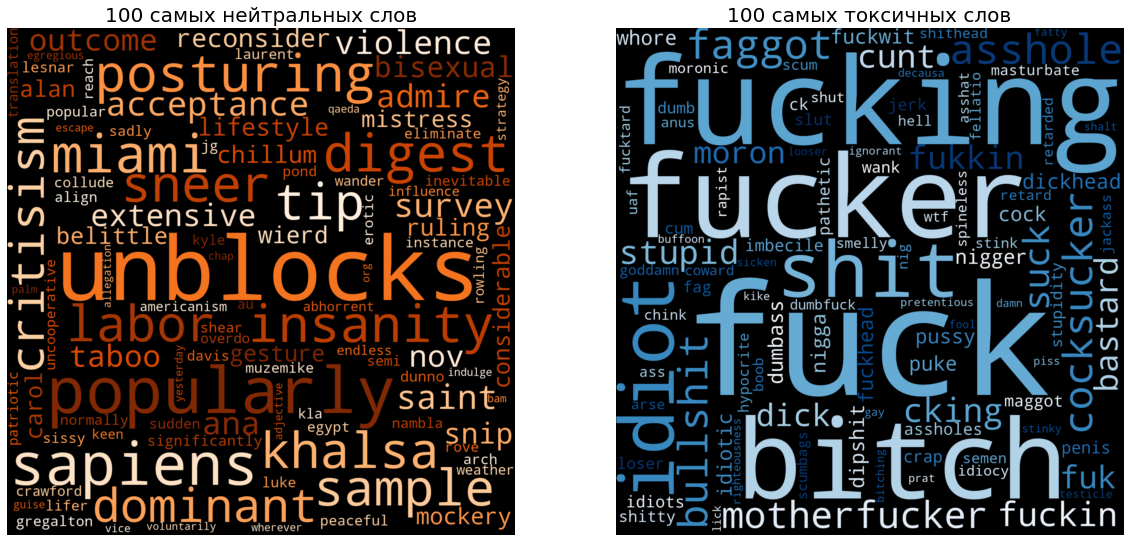

In [36]:
# WordClouds, font size = weight
wordcloud_pos = WordCloud(background_color="black",
                          colormap = 'Oranges',
                          mask=None, 
                          width=1600,
                          height=1600).generate_from_frequencies(
    dict(weights_min.values))

wordcloud_tox = WordCloud(background_color="black",
                          colormap = 'Blues',
                          mask=None, 
                          width=1600,
                          height=1600).generate_from_frequencies(
    dict(weights_max.values))

fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].imshow(wordcloud_tox, interpolation='bilinear')

ax[0].set_title('100 самых нейтральных слов', fontsize = 20)
ax[1].set_title('100 самых токсичных слов', fontsize = 20)

ax[0].axis("off")
ax[1].axis("off")

plt.show()

Видно, что предсказанные моделью самые популярные нейтральные слова действительно нейтральны, но отличаются от самых популярных слов в нейтральных комментариях. Все слова, предсказанные моделью как токсичные, действительно относятся к обсценной и ненормативной лексике, некоторые из них повторяются и среди самых популярных слов токсичных комментариев.

## Общий вывод:

Для задачи построения модели для классификации комментариев на токсичные и нетоксичные был использован датасет из почти 160 тысяч комментариев на английском языке. В датасете большинство (90%) комментариев было нетоксичными.
Перед обучением моделей была проведена предобработка текстов комментариев:
- приведение к нижнему регистру;
- удаление html тегов и гиперссылок;
- удаление пунктуации, цифр и нелатинских символов;
- удаление "технической" информации и никнеймов;
- удаление повторяющихся более 2х раз букв в словах (ex: hellooo->hello, gooood -> good);
- удаление стоп-слов;
- лемматизация с учетом части речи.

Векторизация и подбор гиперпараметров моделей были выполнены с использованием pipeline.

Для векторизации текстов была использована оценка важности слов с помощью *TF-IDF* со следующими параметрами:
- еще раз исключались стоп-слова;
- проверялись модели с учетом не только слов, но и их биграмм;
- не учитывались редкие слова (реже 10); 
- проверялись модели, не учитывающие часто встречающиеся слова (более чем в 50 и 75%).

Были протестированы 3 модели - логистическая регрессия, градиентный бустинг LightGBM и метод опорных векторов. Лучшие показатели качества и скорости показал метод опорных векторов. Для этой модели метрика качества f1 на тестовой выборке составила 0.79, что выше минимально-необходимого значения (0.75).<br>
Доля правильных ответов модели составила 96%, что лучше, чем если бы мы просто всем комментариям присваивали оценку "нетоксичный" (нетоксичных комментариев около 90%).<br>

Для задачи данного проекта важно как правильно находить как можно больше токсичных комментариев, чтобы они не публиковались, а модерировались, так и не загружать модераторов "ложнотоксичными" комментариями. 
У полученной модели правильно определять комментарий как токсичный получается примерно для 70 токсичных комментариев из 100 (recall=0.72). А точность определения токсичных комментариев составила 0.87, что говорит о том, что только 13% комментариев ложно определяются моделью как токсичные. 

Модель быстро предсказывает и обучается. При графическом отображении результата видно, что в комментариях, определяемых моделью как "токсичные" действительно используется обсценная и ненормативная лексика, тогда как в нетоксичных комментариях слова нейтральные.